# Introduction
In this notebook we will attempt to identify cancer in small image patches. We have a large dataset of 96X96 images that are labeled with 0: Benign or 1: Cancerous. We will use Convolutional Neural Networks (CNNs) to model the dataset for binary classification.

While iterating on our model design, we will stick to using a subset of the training data. This is due to time and resource constraints. 

In [ ]:
%pip install numpy pandas PIL torch torchvision matplotlib

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split

from tqdm import tqdm
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from pathlib import Path
workspace = Path.cwd()
df = pd.read_csv(workspace / 'data' / 'train_labels.csv')
df

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


In [3]:
small_df = df.iloc[:5000]

# EDA

For the EDA we will look at:
1. Are the images consistant, in subject matter and size/shape 
2. How balanced is our dataset with respect to labeling

In [4]:
train_images = workspace / 'data' / 'train' 
train_images

PosixPath('/home/jon/code/ms-ds/deeplearning/week_3/data/train')

In [5]:
train_images = list(train_images.glob("*.tif"))


Building an index so I can reference file location during training. Don't want to hold all 220025 images in memory.

In [6]:
train, val = train_test_split(small_df, stratify=small_df.label, test_size=0.2)
len(train), len(val)

(4000, 1000)

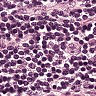

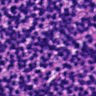

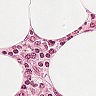

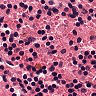

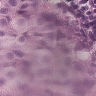

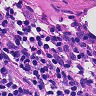

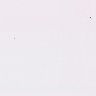

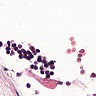

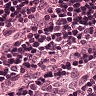

(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)


In [7]:
from PIL import Image
display_images = []
for i in range(9):
    display_images.append(Image.open(train_images[i]))
display(*display_images)
for di in display_images:
    arr = np.array(di)
    print(arr.shape)

Looks like the images are all a consistant 96X96X3. Now that we have examined some of our labels, lets take a look at the outputs

In [8]:
df = df.dropna()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [10]:
df.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


<Axes: xlabel='label'>

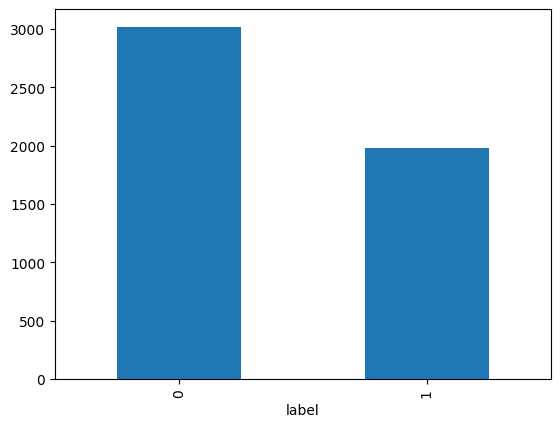

In [11]:
small_df['label'].value_counts().plot(kind='bar')

Not horribly unbalanced.Going to just take random samples from each

In [ ]:
%pip install torchvision

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class ImageDataset(Dataset):
    def __init__(self, df_data, data_dir, transform):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.tif')
        image = Image.open(img_path)
        image = self.transform(image)
        return image, label


/home/jon/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Synthetic data generation 
Here we will make image loaders that will generate random transformation to our training data. This effectively is creating synthetic training samples, which will provide our model more training examples

In [13]:
import torchvision.transforms as transforms
tr_transf = transforms.Compose([transforms.Pad(64, padding_mode='reflect'),
                                  transforms.RandomHorizontalFlip(), 
                                  transforms.RandomVerticalFlip(),
                                  transforms.RandomRotation(20), 
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

data_transformer = transforms.Compose([transforms.Pad(64, padding_mode='reflect'),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

In [14]:
small_train_dataset = ImageDataset(train, workspace / 'data' / 'train',  tr_transf)
small_test_dataset = ImageDataset(val, workspace / 'data' / 'train', data_transformer)
batch_size = 64
train_loader = DataLoader(small_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(small_test_dataset, batch_size=batch_size, shuffle=True)

# Architecture 1. Base ConvNet

This is a shallow CNN that utilizes a sequential network comprised of Conv2d and ReLU activations. Layers contain a batch normalization. The convolution layers are ran first, then linear layers are used to perform a classification. 

In [15]:

import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self, num_classes=2, kernel_size=3, stride=1):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 46, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(46),
            nn.ReLU(inplace=True),
            nn.Conv2d(46, 64, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)

        self.fc1 = nn.Linear(x.shape[1] * x.shape[2] * x.shape[3], 128).to(device)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x 




# Architecture 2. Deep Convnet

This is a deep CNN that increases the number of convolutional layers compared to the base CNN model.  

In [16]:
class ConvNetDeep(nn.Module):
    def __init__(self, num_classes=2, kernel_size=3, stride=1):
        super(ConvNetDeep, self).__init__()
        self.features = nn.Sequential(
            # Conv1
            nn.Conv2d(3, 46, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(46),
            nn.ReLU(inplace=True),
            # Conv2
            nn.Conv2d(46, 64, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Conv 3
            nn.Conv2d(64, 128, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Conv 4
            nn.Conv2d(128, 256, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Conv 5
            nn.Conv2d(256, 512, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)

        self.fc1 = nn.Linear(x.shape[1] * x.shape[2] * x.shape[3], 128).to(device)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [17]:
convnet = ConvNet()

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Training Models
Here we will do an initial training to compare models. We will move forward with the best fitting one for hyperparameter tuning. 

In [19]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.to(device)
    best_val_acc = 0.0
    train_loss = []
    validation_loss = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader.dataset)
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0


        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = correct / total
        train_loss.append(epoch_loss)
        validation_loss.append(val_loss)
        # Log metrics
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"Val Accuracy: {val_accuracy:.4f}")
        print()
    print(train_loss, validation_loss)
    return (train_loss, validation_loss)

## Base CNN

In [30]:
from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(convnet.parameters(), lr=3e-4)

loss = train_model(convnet, train_loader, test_loader, criterion, optimizer, num_epochs=50)

Epoch 1/50: 100%|██████████| 63/63 [01:12<00:00,  1.15s/it]


Epoch 1/50
Train Loss: 0.0109
Val Loss: 0.0109
Val Accuracy: 0.5570



Epoch 2/50: 100%|██████████| 63/63 [00:51<00:00,  1.23it/s]


Epoch 2/50
Train Loss: 0.0105
Val Loss: 0.0104
Val Accuracy: 0.5980



Epoch 3/50: 100%|██████████| 63/63 [00:50<00:00,  1.24it/s]


Epoch 3/50
Train Loss: 0.0102
Val Loss: 0.0103
Val Accuracy: 0.6080



Epoch 4/50: 100%|██████████| 63/63 [00:50<00:00,  1.24it/s]


Epoch 4/50
Train Loss: 0.0101
Val Loss: 0.0101
Val Accuracy: 0.6090



Epoch 5/50: 100%|██████████| 63/63 [00:51<00:00,  1.23it/s]


Epoch 5/50
Train Loss: 0.0100
Val Loss: 0.0099
Val Accuracy: 0.6110



Epoch 6/50: 100%|██████████| 63/63 [00:50<00:00,  1.24it/s]


Epoch 6/50
Train Loss: 0.0099
Val Loss: 0.0100
Val Accuracy: 0.6120



Epoch 7/50: 100%|██████████| 63/63 [00:51<00:00,  1.23it/s]


Epoch 7/50
Train Loss: 0.0099
Val Loss: 0.0098
Val Accuracy: 0.6130



Epoch 8/50: 100%|██████████| 63/63 [00:51<00:00,  1.23it/s]


Epoch 8/50
Train Loss: 0.0098
Val Loss: 0.0097
Val Accuracy: 0.6330



Epoch 9/50: 100%|██████████| 63/63 [00:53<00:00,  1.19it/s]


Epoch 9/50
Train Loss: 0.0097
Val Loss: 0.0096
Val Accuracy: 0.6250



Epoch 10/50: 100%|██████████| 63/63 [00:51<00:00,  1.23it/s]


Epoch 10/50
Train Loss: 0.0097
Val Loss: 0.0096
Val Accuracy: 0.6450



Epoch 11/50: 100%|██████████| 63/63 [00:51<00:00,  1.23it/s]


Epoch 11/50
Train Loss: 0.0096
Val Loss: 0.0096
Val Accuracy: 0.6500



Epoch 12/50: 100%|██████████| 63/63 [00:50<00:00,  1.24it/s]


Epoch 12/50
Train Loss: 0.0096
Val Loss: 0.0094
Val Accuracy: 0.6690



Epoch 13/50: 100%|██████████| 63/63 [00:50<00:00,  1.25it/s]


Epoch 13/50
Train Loss: 0.0095
Val Loss: 0.0095
Val Accuracy: 0.6590



Epoch 14/50: 100%|██████████| 63/63 [00:50<00:00,  1.25it/s]


Epoch 14/50
Train Loss: 0.0095
Val Loss: 0.0094
Val Accuracy: 0.6720



Epoch 15/50: 100%|██████████| 63/63 [00:50<00:00,  1.24it/s]


Epoch 15/50
Train Loss: 0.0095
Val Loss: 0.0094
Val Accuracy: 0.6750



Epoch 16/50: 100%|██████████| 63/63 [00:51<00:00,  1.23it/s]


Epoch 16/50
Train Loss: 0.0094
Val Loss: 0.0094
Val Accuracy: 0.6830



Epoch 17/50: 100%|██████████| 63/63 [00:50<00:00,  1.24it/s]


Epoch 17/50
Train Loss: 0.0093
Val Loss: 0.0092
Val Accuracy: 0.6910



Epoch 18/50: 100%|██████████| 63/63 [00:51<00:00,  1.23it/s]


Epoch 18/50
Train Loss: 0.0093
Val Loss: 0.0092
Val Accuracy: 0.7000



Epoch 19/50: 100%|██████████| 63/63 [00:51<00:00,  1.22it/s]


Epoch 19/50
Train Loss: 0.0092
Val Loss: 0.0092
Val Accuracy: 0.7100



Epoch 20/50: 100%|██████████| 63/63 [00:51<00:00,  1.23it/s]


Epoch 20/50
Train Loss: 0.0092
Val Loss: 0.0092
Val Accuracy: 0.7170



Epoch 21/50: 100%|██████████| 63/63 [00:50<00:00,  1.24it/s]


Epoch 21/50
Train Loss: 0.0092
Val Loss: 0.0093
Val Accuracy: 0.6990



Epoch 22/50: 100%|██████████| 63/63 [00:50<00:00,  1.24it/s]


Epoch 22/50
Train Loss: 0.0091
Val Loss: 0.0091
Val Accuracy: 0.7230



Epoch 23/50: 100%|██████████| 63/63 [00:50<00:00,  1.24it/s]


Epoch 23/50
Train Loss: 0.0091
Val Loss: 0.0091
Val Accuracy: 0.7160



Epoch 24/50: 100%|██████████| 63/63 [00:50<00:00,  1.24it/s]


Epoch 24/50
Train Loss: 0.0091
Val Loss: 0.0091
Val Accuracy: 0.7330



Epoch 25/50: 100%|██████████| 63/63 [00:51<00:00,  1.22it/s]


Epoch 25/50
Train Loss: 0.0090
Val Loss: 0.0090
Val Accuracy: 0.7260



Epoch 26/50: 100%|██████████| 63/63 [00:50<00:00,  1.24it/s]


Epoch 26/50
Train Loss: 0.0091
Val Loss: 0.0091
Val Accuracy: 0.7320



Epoch 27/50: 100%|██████████| 63/63 [00:51<00:00,  1.23it/s]


Epoch 27/50
Train Loss: 0.0090
Val Loss: 0.0089
Val Accuracy: 0.7370



Epoch 28/50: 100%|██████████| 63/63 [00:50<00:00,  1.24it/s]


Epoch 28/50
Train Loss: 0.0090
Val Loss: 0.0088
Val Accuracy: 0.7230



Epoch 29/50: 100%|██████████| 63/63 [00:50<00:00,  1.25it/s]


Epoch 29/50
Train Loss: 0.0089
Val Loss: 0.0090
Val Accuracy: 0.7310



Epoch 30/50: 100%|██████████| 63/63 [00:50<00:00,  1.24it/s]


Epoch 30/50
Train Loss: 0.0089
Val Loss: 0.0090
Val Accuracy: 0.7210



Epoch 31/50: 100%|██████████| 63/63 [00:51<00:00,  1.23it/s]


Epoch 31/50
Train Loss: 0.0089
Val Loss: 0.0088
Val Accuracy: 0.7340



Epoch 32/50: 100%|██████████| 63/63 [00:50<00:00,  1.24it/s]


Epoch 32/50
Train Loss: 0.0089
Val Loss: 0.0089
Val Accuracy: 0.7340



Epoch 33/50: 100%|██████████| 63/63 [00:51<00:00,  1.23it/s]


Epoch 33/50
Train Loss: 0.0089
Val Loss: 0.0089
Val Accuracy: 0.7430



Epoch 34/50: 100%|██████████| 63/63 [00:50<00:00,  1.26it/s]


Epoch 34/50
Train Loss: 0.0089
Val Loss: 0.0087
Val Accuracy: 0.7510



Epoch 35/50: 100%|██████████| 63/63 [00:50<00:00,  1.26it/s]


Epoch 35/50
Train Loss: 0.0088
Val Loss: 0.0087
Val Accuracy: 0.7590



Epoch 36/50: 100%|██████████| 63/63 [00:49<00:00,  1.26it/s]


Epoch 36/50
Train Loss: 0.0088
Val Loss: 0.0088
Val Accuracy: 0.7540



Epoch 37/50: 100%|██████████| 63/63 [00:50<00:00,  1.26it/s]


Epoch 37/50
Train Loss: 0.0088
Val Loss: 0.0087
Val Accuracy: 0.7590



Epoch 38/50: 100%|██████████| 63/63 [00:50<00:00,  1.25it/s]


Epoch 38/50
Train Loss: 0.0088
Val Loss: 0.0087
Val Accuracy: 0.7590



Epoch 39/50: 100%|██████████| 63/63 [00:50<00:00,  1.25it/s]


Epoch 39/50
Train Loss: 0.0087
Val Loss: 0.0088
Val Accuracy: 0.7490



Epoch 40/50: 100%|██████████| 63/63 [00:50<00:00,  1.25it/s]


Epoch 40/50
Train Loss: 0.0087
Val Loss: 0.0087
Val Accuracy: 0.7470



Epoch 41/50: 100%|██████████| 63/63 [00:50<00:00,  1.26it/s]


Epoch 41/50
Train Loss: 0.0086
Val Loss: 0.0085
Val Accuracy: 0.7650



Epoch 42/50: 100%|██████████| 63/63 [00:50<00:00,  1.26it/s]


Epoch 42/50
Train Loss: 0.0087
Val Loss: 0.0086
Val Accuracy: 0.7720



Epoch 43/50: 100%|██████████| 63/63 [00:50<00:00,  1.24it/s]


Epoch 43/50
Train Loss: 0.0086
Val Loss: 0.0086
Val Accuracy: 0.7530



Epoch 44/50: 100%|██████████| 63/63 [00:51<00:00,  1.22it/s]


Epoch 44/50
Train Loss: 0.0086
Val Loss: 0.0086
Val Accuracy: 0.7550



Epoch 45/50: 100%|██████████| 63/63 [00:52<00:00,  1.21it/s]


Epoch 45/50
Train Loss: 0.0086
Val Loss: 0.0086
Val Accuracy: 0.7700



Epoch 46/50: 100%|██████████| 63/63 [00:53<00:00,  1.19it/s]


Epoch 46/50
Train Loss: 0.0086
Val Loss: 0.0085
Val Accuracy: 0.7670



Epoch 47/50: 100%|██████████| 63/63 [00:52<00:00,  1.19it/s]


Epoch 47/50
Train Loss: 0.0086
Val Loss: 0.0088
Val Accuracy: 0.7680



Epoch 48/50: 100%|██████████| 63/63 [00:52<00:00,  1.20it/s]


Epoch 48/50
Train Loss: 0.0085
Val Loss: 0.0087
Val Accuracy: 0.7550



Epoch 49/50: 100%|██████████| 63/63 [00:51<00:00,  1.22it/s]


Epoch 49/50
Train Loss: 0.0085
Val Loss: 0.0085
Val Accuracy: 0.7670



Epoch 50/50: 100%|██████████| 63/63 [00:51<00:00,  1.23it/s]


Epoch 50/50
Train Loss: 0.0085
Val Loss: 0.0085
Val Accuracy: 0.7700

[0.010943502008914948, 0.010520681276917458, 0.010217185914516449, 0.010091655895113944, 0.010003132745623589, 0.009914966881275177, 0.009852933540940285, 0.009835071101784706, 0.009703566312789918, 0.009703505650162697, 0.009609916232526302, 0.009574515759944916, 0.009520411185920239, 0.009472083248198033, 0.009457549035549163, 0.009429267391562461, 0.009327556170523168, 0.009323427282273769, 0.009241728357970715, 0.009228471234440804, 0.009195993050932884, 0.009129052549600601, 0.009120637521147728, 0.009128374427556991, 0.009029583856463432, 0.009063177593052387, 0.009009469091892243, 0.00899750779569149, 0.008940128415822982, 0.00890016507357359, 0.008890833660960197, 0.008922390967607498, 0.008871498860418797, 0.008870142601430417, 0.008838287837803363, 0.008765420779585838, 0.008815856508910655, 0.00876394110172987, 0.00874243225157261, 0.008704407200217246, 0.008637343436479568, 0.008673023715615272, 0.0086462

/tmp/ipykernel_322/1064595102.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


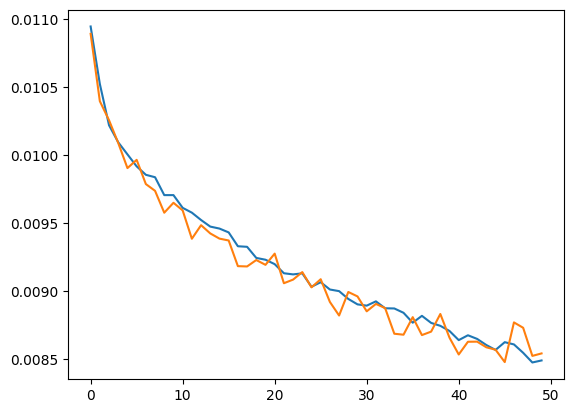

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(loss[0])
ax.plot(loss[1])
fig.show()

## Deep CNN

In [32]:
convnetdeep = ConvNetDeep(2)

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(convnetdeep.parameters(), lr=3e-4)

deep_conv_net_loss = train_model(convnetdeep, train_loader, test_loader, criterion, optimizer, num_epochs=50)

Epoch 1/50: 100%|██████████| 63/63 [00:21<00:00,  2.98it/s]


Epoch 1/50
Train Loss: 0.0107
Val Loss: 0.0106
Val Accuracy: 0.5890



Epoch 2/50: 100%|██████████| 63/63 [00:19<00:00,  3.18it/s]


Epoch 2/50
Train Loss: 0.0102
Val Loss: 0.0102
Val Accuracy: 0.5790



Epoch 3/50: 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]


Epoch 3/50
Train Loss: 0.0097
Val Loss: 0.0095
Val Accuracy: 0.6040



Epoch 4/50: 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]


Epoch 4/50
Train Loss: 0.0092
Val Loss: 0.0093
Val Accuracy: 0.6040



Epoch 5/50: 100%|██████████| 63/63 [00:19<00:00,  3.24it/s]


Epoch 5/50
Train Loss: 0.0089
Val Loss: 0.0090
Val Accuracy: 0.7160



Epoch 6/50: 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]


Epoch 6/50
Train Loss: 0.0088
Val Loss: 0.0090
Val Accuracy: 0.7230



Epoch 7/50: 100%|██████████| 63/63 [00:19<00:00,  3.28it/s]


Epoch 7/50
Train Loss: 0.0087
Val Loss: 0.0091
Val Accuracy: 0.7570



Epoch 8/50: 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]


Epoch 8/50
Train Loss: 0.0086
Val Loss: 0.0088
Val Accuracy: 0.7220



Epoch 9/50: 100%|██████████| 63/63 [00:19<00:00,  3.24it/s]


Epoch 9/50
Train Loss: 0.0086
Val Loss: 0.0087
Val Accuracy: 0.7470



Epoch 10/50: 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]


Epoch 10/50
Train Loss: 0.0084
Val Loss: 0.0088
Val Accuracy: 0.7400



Epoch 11/50: 100%|██████████| 63/63 [00:19<00:00,  3.19it/s]


Epoch 11/50
Train Loss: 0.0085
Val Loss: 0.0087
Val Accuracy: 0.7450



Epoch 12/50: 100%|██████████| 63/63 [00:20<00:00,  3.11it/s]


Epoch 12/50
Train Loss: 0.0083
Val Loss: 0.0085
Val Accuracy: 0.7670



Epoch 13/50: 100%|██████████| 63/63 [00:20<00:00,  3.13it/s]


Epoch 13/50
Train Loss: 0.0082
Val Loss: 0.0085
Val Accuracy: 0.7690



Epoch 14/50: 100%|██████████| 63/63 [00:19<00:00,  3.20it/s]


Epoch 14/50
Train Loss: 0.0082
Val Loss: 0.0085
Val Accuracy: 0.7640



Epoch 15/50: 100%|██████████| 63/63 [00:19<00:00,  3.21it/s]


Epoch 15/50
Train Loss: 0.0081
Val Loss: 0.0082
Val Accuracy: 0.7780



Epoch 16/50: 100%|██████████| 63/63 [00:19<00:00,  3.20it/s]


Epoch 16/50
Train Loss: 0.0081
Val Loss: 0.0082
Val Accuracy: 0.7590



Epoch 17/50: 100%|██████████| 63/63 [00:19<00:00,  3.22it/s]


Epoch 17/50
Train Loss: 0.0080
Val Loss: 0.0084
Val Accuracy: 0.7840



Epoch 18/50: 100%|██████████| 63/63 [00:19<00:00,  3.20it/s]


Epoch 18/50
Train Loss: 0.0080
Val Loss: 0.0083
Val Accuracy: 0.7850



Epoch 19/50: 100%|██████████| 63/63 [00:19<00:00,  3.22it/s]


Epoch 19/50
Train Loss: 0.0079
Val Loss: 0.0085
Val Accuracy: 0.7680



Epoch 20/50: 100%|██████████| 63/63 [00:19<00:00,  3.17it/s]


Epoch 20/50
Train Loss: 0.0079
Val Loss: 0.0079
Val Accuracy: 0.7770



Epoch 21/50: 100%|██████████| 63/63 [00:19<00:00,  3.19it/s]


Epoch 21/50
Train Loss: 0.0077
Val Loss: 0.0080
Val Accuracy: 0.7780



Epoch 22/50: 100%|██████████| 63/63 [00:19<00:00,  3.18it/s]


Epoch 22/50
Train Loss: 0.0078
Val Loss: 0.0080
Val Accuracy: 0.7710



Epoch 23/50: 100%|██████████| 63/63 [00:19<00:00,  3.18it/s]


Epoch 23/50
Train Loss: 0.0077
Val Loss: 0.0085
Val Accuracy: 0.7550



Epoch 24/50: 100%|██████████| 63/63 [00:19<00:00,  3.19it/s]


Epoch 24/50
Train Loss: 0.0078
Val Loss: 0.0077
Val Accuracy: 0.7780



Epoch 25/50: 100%|██████████| 63/63 [00:19<00:00,  3.17it/s]


Epoch 25/50
Train Loss: 0.0076
Val Loss: 0.0081
Val Accuracy: 0.7720



Epoch 26/50: 100%|██████████| 63/63 [00:19<00:00,  3.17it/s]


Epoch 26/50
Train Loss: 0.0076
Val Loss: 0.0080
Val Accuracy: 0.7810



Epoch 27/50: 100%|██████████| 63/63 [00:20<00:00,  3.15it/s]


Epoch 27/50
Train Loss: 0.0076
Val Loss: 0.0077
Val Accuracy: 0.7800



Epoch 28/50: 100%|██████████| 63/63 [00:19<00:00,  3.17it/s]


Epoch 28/50
Train Loss: 0.0075
Val Loss: 0.0075
Val Accuracy: 0.7910



Epoch 29/50: 100%|██████████| 63/63 [00:19<00:00,  3.20it/s]


Epoch 29/50
Train Loss: 0.0075
Val Loss: 0.0077
Val Accuracy: 0.7730



Epoch 30/50: 100%|██████████| 63/63 [00:19<00:00,  3.21it/s]


Epoch 30/50
Train Loss: 0.0074
Val Loss: 0.0075
Val Accuracy: 0.7910



Epoch 31/50: 100%|██████████| 63/63 [00:19<00:00,  3.20it/s]


Epoch 31/50
Train Loss: 0.0074
Val Loss: 0.0075
Val Accuracy: 0.8030



Epoch 32/50: 100%|██████████| 63/63 [00:19<00:00,  3.22it/s]


Epoch 32/50
Train Loss: 0.0073
Val Loss: 0.0077
Val Accuracy: 0.7690



Epoch 33/50: 100%|██████████| 63/63 [00:19<00:00,  3.20it/s]


Epoch 33/50
Train Loss: 0.0074
Val Loss: 0.0077
Val Accuracy: 0.7890



Epoch 34/50: 100%|██████████| 63/63 [00:19<00:00,  3.17it/s]


Epoch 34/50
Train Loss: 0.0072
Val Loss: 0.0074
Val Accuracy: 0.7930



Epoch 35/50: 100%|██████████| 63/63 [00:19<00:00,  3.19it/s]


Epoch 35/50
Train Loss: 0.0072
Val Loss: 0.0074
Val Accuracy: 0.7930



Epoch 36/50: 100%|██████████| 63/63 [00:19<00:00,  3.21it/s]


Epoch 36/50
Train Loss: 0.0072
Val Loss: 0.0074
Val Accuracy: 0.8040



Epoch 37/50: 100%|██████████| 63/63 [00:19<00:00,  3.21it/s]


Epoch 37/50
Train Loss: 0.0071
Val Loss: 0.0076
Val Accuracy: 0.7870



Epoch 38/50: 100%|██████████| 63/63 [00:19<00:00,  3.21it/s]


Epoch 38/50
Train Loss: 0.0071
Val Loss: 0.0074
Val Accuracy: 0.7840



Epoch 39/50: 100%|██████████| 63/63 [00:19<00:00,  3.21it/s]


Epoch 39/50
Train Loss: 0.0071
Val Loss: 0.0072
Val Accuracy: 0.8010



Epoch 40/50: 100%|██████████| 63/63 [00:19<00:00,  3.21it/s]


Epoch 40/50
Train Loss: 0.0070
Val Loss: 0.0072
Val Accuracy: 0.7930



Epoch 41/50: 100%|██████████| 63/63 [00:19<00:00,  3.22it/s]


Epoch 41/50
Train Loss: 0.0071
Val Loss: 0.0077
Val Accuracy: 0.7810



Epoch 42/50: 100%|██████████| 63/63 [00:19<00:00,  3.21it/s]


Epoch 42/50
Train Loss: 0.0071
Val Loss: 0.0070
Val Accuracy: 0.8020



Epoch 43/50: 100%|██████████| 63/63 [00:19<00:00,  3.21it/s]


Epoch 43/50
Train Loss: 0.0069
Val Loss: 0.0073
Val Accuracy: 0.7790



Epoch 44/50: 100%|██████████| 63/63 [00:19<00:00,  3.21it/s]


Epoch 44/50
Train Loss: 0.0069
Val Loss: 0.0069
Val Accuracy: 0.8020



Epoch 45/50: 100%|██████████| 63/63 [00:19<00:00,  3.21it/s]


Epoch 45/50
Train Loss: 0.0068
Val Loss: 0.0070
Val Accuracy: 0.8050



Epoch 46/50: 100%|██████████| 63/63 [00:19<00:00,  3.20it/s]


Epoch 46/50
Train Loss: 0.0068
Val Loss: 0.0075
Val Accuracy: 0.7990



Epoch 47/50: 100%|██████████| 63/63 [00:19<00:00,  3.20it/s]


Epoch 47/50
Train Loss: 0.0068
Val Loss: 0.0081
Val Accuracy: 0.7620



Epoch 48/50: 100%|██████████| 63/63 [00:19<00:00,  3.19it/s]


Epoch 48/50
Train Loss: 0.0068
Val Loss: 0.0068
Val Accuracy: 0.8110



Epoch 49/50: 100%|██████████| 63/63 [00:19<00:00,  3.20it/s]


Epoch 49/50
Train Loss: 0.0068
Val Loss: 0.0071
Val Accuracy: 0.8080



Epoch 50/50: 100%|██████████| 63/63 [00:19<00:00,  3.20it/s]


Epoch 50/50
Train Loss: 0.0067
Val Loss: 0.0069
Val Accuracy: 0.7970

[0.01070964641869068, 0.010222266539931297, 0.009697102412581444, 0.009239390693604946, 0.008911960452795029, 0.008842685878276826, 0.008688299350440503, 0.00861706106364727, 0.008582749366760255, 0.008447541877627373, 0.008504497833549977, 0.008303466640412807, 0.008193829700350761, 0.008150492236018181, 0.008107343278825284, 0.008089366033673287, 0.008043282315135002, 0.008043224312365056, 0.007920975618064404, 0.007903506234288215, 0.007676940836012364, 0.007821220509707927, 0.00769572477787733, 0.007765032939612866, 0.007649861618876457, 0.007571283951401711, 0.007573410533368587, 0.007506441876292229, 0.00748125646263361, 0.007416167423129082, 0.007433301582932472, 0.0072715656161308284, 0.007368866533041, 0.00724145594984293, 0.007242066517472267, 0.0071942413970828055, 0.007112910740077496, 0.007086173035204411, 0.007051334269344806, 0.006996967293322086, 0.007073189698159695, 0.007070420719683171, 0.006885282

/tmp/ipykernel_322/3085517904.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


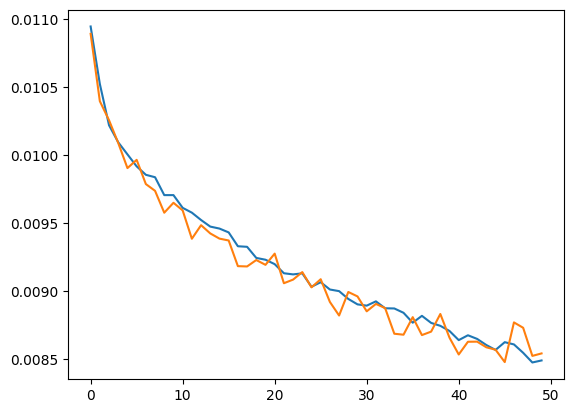

In [34]:
fig, ax = plt.subplots()
ax.plot(loss[0])
ax.plot(loss[1])
fig.show()

Looks like the deep CNN did a better job of fitting the data. It does not appear either of the models fully converged, so we should adjust the learning rate or extend the training epochs. We will include that in the hyperparameter tuning in the next step.

# Hyper Parameter Tuning
Due to limitations of compute resources, I am just going to do a grid search on our parameters. For a full optimization, it would be more appropriate to use a numerical optimization technique like a genetetic algorithm to tune the parameters. I'll also only be testing on 5 epochs for each parameter test, this is again due to time and resource constraints.  

In [ ]:
%pip install scikit-learn

In [35]:
import itertools
from sklearn.model_selection import ParameterGrid

In [36]:
def train_and_evaluate(model, optimizer, train_loader, val_loader):
  criterion = nn.CrossEntropyLoss()
  loss = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)
  return loss

def grid_search(model_class, param_grid, train_loader, val_loader):
  results = []
  for params in tqdm(ParameterGrid(param_grid)):
    model = model_class(2, kernel_size=params['kernel_size'], stride=params['stride'])
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])
    val_accuracy = train_and_evaluate(model, optimizer, train_loader, val_loader)
    results.append({**params, 'val_accuracy': val_accuracy[-1]})

  return results


In [43]:

param_grid = {
    'lr': [5e-5, 1e-4, 3e-4],
    'kernel_size': [1, 3, 5],
    'stride': [1],

}
deep_conv_results = grid_search(ConvNetDeep, param_grid, train_loader, test_loader)

Epoch 1/5: 100%|██████████| 63/63 [00:19<00:00,  3.31it/s]


Epoch 1/5
Train Loss: 0.0111
Val Loss: 0.0111
Val Accuracy: 0.5250



Epoch 2/5: 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]


Epoch 2/5
Train Loss: 0.0109
Val Loss: 0.0110
Val Accuracy: 0.5540



Epoch 3/5: 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]


Epoch 3/5
Train Loss: 0.0108
Val Loss: 0.0110
Val Accuracy: 0.5290



Epoch 4/5: 100%|██████████| 63/63 [00:18<00:00,  3.40it/s]


Epoch 4/5
Train Loss: 0.0108
Val Loss: 0.0108
Val Accuracy: 0.5910



 11%|█         | 1/9 [01:49<14:32, 109.05s/it]

Epoch 5/5
Train Loss: 0.0107
Val Loss: 0.0109
Val Accuracy: 0.5840

[0.011065949872136115, 0.010868040174245834, 0.010837335333228112, 0.010768501356244088, 0.010681692123413087] [0.01113882166147232, 0.010971500098705293, 0.011003167390823364, 0.010837036073207856, 0.010885341882705688]


Epoch 1/5: 100%|██████████| 63/63 [00:18<00:00,  3.44it/s]


Epoch 1/5
Train Loss: 0.0112
Val Loss: 0.0111
Val Accuracy: 0.5300



Epoch 2/5: 100%|██████████| 63/63 [00:18<00:00,  3.45it/s]


Epoch 2/5
Train Loss: 0.0108
Val Loss: 0.0109
Val Accuracy: 0.5610



Epoch 3/5: 100%|██████████| 63/63 [00:18<00:00,  3.40it/s]


Epoch 3/5
Train Loss: 0.0108
Val Loss: 0.0108
Val Accuracy: 0.5730



Epoch 4/5: 100%|██████████| 63/63 [00:18<00:00,  3.43it/s]


Epoch 4/5
Train Loss: 0.0106
Val Loss: 0.0108
Val Accuracy: 0.5870



 22%|██▏       | 2/9 [03:34<12:29, 107.08s/it]

Epoch 5/5
Train Loss: 0.0106
Val Loss: 0.0108
Val Accuracy: 0.5790

[0.011178354620933533, 0.010791650965809823, 0.010807270497083663, 0.010597457960247993, 0.010596114665269852] [0.01112291395664215, 0.01094704133272171, 0.010794280171394348, 0.010782488465309143, 0.010791183412075044]


Epoch 1/5: 100%|██████████| 63/63 [00:18<00:00,  3.43it/s]


Epoch 1/5
Train Loss: 0.0107
Val Loss: 0.0112
Val Accuracy: 0.5670



Epoch 2/5: 100%|██████████| 63/63 [00:18<00:00,  3.42it/s]


Epoch 2/5
Train Loss: 0.0106
Val Loss: 0.0109
Val Accuracy: 0.5770



Epoch 3/5: 100%|██████████| 63/63 [00:18<00:00,  3.43it/s]


Epoch 3/5
Train Loss: 0.0105
Val Loss: 0.0107
Val Accuracy: 0.6000



Epoch 4/5: 100%|██████████| 63/63 [00:18<00:00,  3.42it/s]


Epoch 4/5
Train Loss: 0.0104
Val Loss: 0.0105
Val Accuracy: 0.6050



 33%|███▎      | 3/9 [05:20<10:39, 106.56s/it]

Epoch 5/5
Train Loss: 0.0102
Val Loss: 0.0103
Val Accuracy: 0.6030

[0.010725384294986725, 0.010617052391171455, 0.010537050634622574, 0.010430950790643692, 0.010221055194735528] [0.0111671382188797, 0.0109107466340065, 0.010656993567943572, 0.010526807963848113, 0.0103133145570755]


Epoch 1/5: 100%|██████████| 63/63 [00:19<00:00,  3.23it/s]


Epoch 1/5
Train Loss: 0.0108
Val Loss: 0.0110
Val Accuracy: 0.5490



Epoch 2/5: 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]


Epoch 2/5
Train Loss: 0.0107
Val Loss: 0.0107
Val Accuracy: 0.5690



Epoch 3/5: 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]


Epoch 3/5
Train Loss: 0.0105
Val Loss: 0.0105
Val Accuracy: 0.6030



Epoch 4/5: 100%|██████████| 63/63 [00:19<00:00,  3.28it/s]


Epoch 4/5
Train Loss: 0.0105
Val Loss: 0.0105
Val Accuracy: 0.6150



 44%|████▍     | 4/9 [07:09<08:56, 107.32s/it]

Epoch 5/5
Train Loss: 0.0103
Val Loss: 0.0102
Val Accuracy: 0.5900

[0.010793985247612, 0.010701411381363869, 0.010506552129983903, 0.010542208954691887, 0.010274286895990371] [0.010972374439239502, 0.010710850775241853, 0.010493017375469208, 0.010538546442985535, 0.010228163480758667]


Epoch 1/5: 100%|██████████| 63/63 [00:19<00:00,  3.24it/s]


Epoch 1/5
Train Loss: 0.0107
Val Loss: 0.0106
Val Accuracy: 0.5840



Epoch 2/5: 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]


Epoch 2/5
Train Loss: 0.0105
Val Loss: 0.0105
Val Accuracy: 0.5800



Epoch 3/5: 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]


Epoch 3/5
Train Loss: 0.0103
Val Loss: 0.0101
Val Accuracy: 0.6080



Epoch 4/5: 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]


Epoch 4/5
Train Loss: 0.0100
Val Loss: 0.0098
Val Accuracy: 0.6110



 56%|█████▌    | 5/9 [08:57<07:11, 107.85s/it]

Epoch 5/5
Train Loss: 0.0097
Val Loss: 0.0097
Val Accuracy: 0.5970

[0.010683472067117691, 0.01046749660372734, 0.010293056026101113, 0.010009541884064674, 0.009714574366807938] [0.010648124456405639, 0.01049477607011795, 0.010143289148807525, 0.009791253238916397, 0.009699691593647003]


Epoch 1/5: 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]


Epoch 1/5
Train Loss: 0.0110
Val Loss: 0.0108
Val Accuracy: 0.6010



Epoch 2/5: 100%|██████████| 63/63 [00:19<00:00,  3.28it/s]


Epoch 2/5
Train Loss: 0.0104
Val Loss: 0.0103
Val Accuracy: 0.6040



Epoch 3/5: 100%|██████████| 63/63 [00:19<00:00,  3.28it/s]


Epoch 3/5
Train Loss: 0.0097
Val Loss: 0.0095
Val Accuracy: 0.6040



Epoch 4/5: 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]


Epoch 4/5
Train Loss: 0.0092
Val Loss: 0.0091
Val Accuracy: 0.6100



 67%|██████▋   | 6/9 [10:46<05:24, 108.04s/it]

Epoch 5/5
Train Loss: 0.0089
Val Loss: 0.0089
Val Accuracy: 0.7090

[0.010964478060603142, 0.010378049999475478, 0.00974405100941658, 0.009241318807005882, 0.008913867034018039] [0.010771469473838806, 0.01026166445016861, 0.009535489976406098, 0.00908007487654686, 0.00893262618780136]


Epoch 1/5: 100%|██████████| 63/63 [00:23<00:00,  2.63it/s]


Epoch 1/5
Train Loss: 0.0111
Val Loss: 0.0111
Val Accuracy: 0.5250



Epoch 2/5: 100%|██████████| 63/63 [00:23<00:00,  2.64it/s]


Epoch 2/5
Train Loss: 0.0108
Val Loss: 0.0108
Val Accuracy: 0.5750



Epoch 3/5: 100%|██████████| 63/63 [00:24<00:00,  2.62it/s]


Epoch 3/5
Train Loss: 0.0108
Val Loss: 0.0110
Val Accuracy: 0.5220



Epoch 4/5: 100%|██████████| 63/63 [00:23<00:00,  2.64it/s]


Epoch 4/5
Train Loss: 0.0106
Val Loss: 0.0109
Val Accuracy: 0.5590



 78%|███████▊  | 7/9 [12:57<03:51, 115.56s/it]

Epoch 5/5
Train Loss: 0.0105
Val Loss: 0.0106
Val Accuracy: 0.5840

[0.011120173797011376, 0.010843160673975944, 0.010757739245891572, 0.01064322279393673, 0.010482591554522514] [0.011099088311195373, 0.010807191669940949, 0.010952424049377442, 0.01093300187587738, 0.010573700487613679]


Epoch 1/5: 100%|██████████| 63/63 [00:24<00:00,  2.61it/s]


Epoch 1/5
Train Loss: 0.0111
Val Loss: 0.0112
Val Accuracy: 0.4840



Epoch 2/5: 100%|██████████| 63/63 [00:23<00:00,  2.63it/s]


Epoch 2/5
Train Loss: 0.0108
Val Loss: 0.0109
Val Accuracy: 0.5420



Epoch 3/5: 100%|██████████| 63/63 [00:23<00:00,  2.63it/s]


Epoch 3/5
Train Loss: 0.0106
Val Loss: 0.0105
Val Accuracy: 0.5650



Epoch 4/5: 100%|██████████| 63/63 [00:23<00:00,  2.63it/s]


Epoch 4/5
Train Loss: 0.0102
Val Loss: 0.0100
Val Accuracy: 0.5980



 89%|████████▉ | 8/9 [15:09<02:00, 120.73s/it]

Epoch 5/5
Train Loss: 0.0098
Val Loss: 0.0096
Val Accuracy: 0.6040

[0.011061470597982407, 0.010849352806806564, 0.010565534263849258, 0.010159140884876251, 0.009763664096593856] [0.01123446375131607, 0.010873912513256073, 0.010521051347255707, 0.010001606583595276, 0.00962224006652832]


Epoch 1/5: 100%|██████████| 63/63 [00:23<00:00,  2.63it/s]


Epoch 1/5
Train Loss: 0.0106
Val Loss: 0.0105
Val Accuracy: 0.6010



Epoch 2/5: 100%|██████████| 63/63 [00:23<00:00,  2.63it/s]


Epoch 2/5
Train Loss: 0.0099
Val Loss: 0.0094
Val Accuracy: 0.6040



Epoch 3/5: 100%|██████████| 63/63 [00:23<00:00,  2.63it/s]


Epoch 3/5
Train Loss: 0.0093
Val Loss: 0.0090
Val Accuracy: 0.6040



Epoch 4/5: 100%|██████████| 63/63 [00:23<00:00,  2.63it/s]


Epoch 4/5
Train Loss: 0.0088
Val Loss: 0.0093
Val Accuracy: 0.7390



100%|██████████| 9/9 [17:20<00:00, 115.61s/it]

Epoch 5/5
Train Loss: 0.0086
Val Loss: 0.0087
Val Accuracy: 0.7250

[0.010597503304481507, 0.009862590283155441, 0.009313487455248832, 0.008825076036155224, 0.008648186326026916] [0.010468877255916595, 0.009409165501594544, 0.009038580864667892, 0.009348765909671784, 0.008692741900682449]


# Results

Looks like we have found our optimal parameters, lets train this with 50 epochs and compare against the untuned version

In [44]:

best_deep_conv_results = sorted(deep_conv_results, key=lambda x: x['val_accuracy'], reverse=True)[0]
print(best_deep_conv_results)

{'kernel_size': 5, 'lr': 0.0001, 'stride': 1, 'val_accuracy': [0.01123446375131607, 0.010873912513256073, 0.010521051347255707, 0.010001606583595276, 0.00962224006652832]}


### Training tuned deep model on 50 epochs

In [45]:


best_deep_conv_model = ConvNetDeep(2, kernel_size=best_deep_conv_results['kernel_size'], stride=best_deep_conv_results['stride'])
base_deep_learning_rate = best_deep_conv_results['lr']

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_deep_conv_model.parameters(), lr=best_deep_conv_results['lr'])

deep_model_loss_tuned = train_model(best_deep_conv_model, train_loader, test_loader, criterion, optimizer, num_epochs=50)

Epoch 1/50: 100%|██████████| 63/63 [00:24<00:00,  2.62it/s]


Epoch 1/50
Train Loss: 0.0109
Val Loss: 0.0109
Val Accuracy: 0.5460



Epoch 2/50: 100%|██████████| 63/63 [00:24<00:00,  2.61it/s]


Epoch 2/50
Train Loss: 0.0104
Val Loss: 0.0107
Val Accuracy: 0.5500



Epoch 3/50: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 3/50
Train Loss: 0.0103
Val Loss: 0.0102
Val Accuracy: 0.6030



Epoch 4/50: 100%|██████████| 63/63 [00:24<00:00,  2.61it/s]


Epoch 4/50
Train Loss: 0.0099
Val Loss: 0.0101
Val Accuracy: 0.5970



Epoch 5/50: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 5/50
Train Loss: 0.0096
Val Loss: 0.0098
Val Accuracy: 0.6050



Epoch 6/50: 100%|██████████| 63/63 [00:24<00:00,  2.62it/s]


Epoch 6/50
Train Loss: 0.0093
Val Loss: 0.0093
Val Accuracy: 0.6040



Epoch 7/50: 100%|██████████| 63/63 [00:24<00:00,  2.61it/s]


Epoch 7/50
Train Loss: 0.0090
Val Loss: 0.0089
Val Accuracy: 0.6040



Epoch 8/50: 100%|██████████| 63/63 [00:24<00:00,  2.61it/s]


Epoch 8/50
Train Loss: 0.0089
Val Loss: 0.0091
Val Accuracy: 0.6040



Epoch 9/50: 100%|██████████| 63/63 [00:24<00:00,  2.61it/s]


Epoch 9/50
Train Loss: 0.0089
Val Loss: 0.0090
Val Accuracy: 0.6040



Epoch 10/50: 100%|██████████| 63/63 [00:24<00:00,  2.61it/s]


Epoch 10/50
Train Loss: 0.0089
Val Loss: 0.0089
Val Accuracy: 0.6040



Epoch 11/50: 100%|██████████| 63/63 [00:24<00:00,  2.61it/s]


Epoch 11/50
Train Loss: 0.0087
Val Loss: 0.0087
Val Accuracy: 0.6040



Epoch 12/50: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 12/50
Train Loss: 0.0087
Val Loss: 0.0088
Val Accuracy: 0.6040



Epoch 13/50: 100%|██████████| 63/63 [00:23<00:00,  2.63it/s]


Epoch 13/50
Train Loss: 0.0088
Val Loss: 0.0087
Val Accuracy: 0.6040



Epoch 14/50: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 14/50
Train Loss: 0.0086
Val Loss: 0.0089
Val Accuracy: 0.7160



Epoch 15/50: 100%|██████████| 63/63 [00:24<00:00,  2.62it/s]


Epoch 15/50
Train Loss: 0.0085
Val Loss: 0.0087
Val Accuracy: 0.7290



Epoch 16/50: 100%|██████████| 63/63 [00:24<00:00,  2.62it/s]


Epoch 16/50
Train Loss: 0.0085
Val Loss: 0.0088
Val Accuracy: 0.7430



Epoch 17/50: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 17/50
Train Loss: 0.0085
Val Loss: 0.0089
Val Accuracy: 0.7380



Epoch 18/50: 100%|██████████| 63/63 [00:24<00:00,  2.60it/s]


Epoch 18/50
Train Loss: 0.0083
Val Loss: 0.0087
Val Accuracy: 0.7160



Epoch 19/50: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 19/50
Train Loss: 0.0084
Val Loss: 0.0085
Val Accuracy: 0.7560



Epoch 20/50: 100%|██████████| 63/63 [00:24<00:00,  2.62it/s]


Epoch 20/50
Train Loss: 0.0084
Val Loss: 0.0085
Val Accuracy: 0.7500



Epoch 21/50: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 21/50
Train Loss: 0.0082
Val Loss: 0.0084
Val Accuracy: 0.7480



Epoch 22/50: 100%|██████████| 63/63 [00:24<00:00,  2.60it/s]


Epoch 22/50
Train Loss: 0.0082
Val Loss: 0.0084
Val Accuracy: 0.7640



Epoch 23/50: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 23/50
Train Loss: 0.0083
Val Loss: 0.0083
Val Accuracy: 0.7690



Epoch 24/50: 100%|██████████| 63/63 [00:24<00:00,  2.62it/s]


Epoch 24/50
Train Loss: 0.0083
Val Loss: 0.0087
Val Accuracy: 0.7620



Epoch 25/50: 100%|██████████| 63/63 [00:24<00:00,  2.62it/s]


Epoch 25/50
Train Loss: 0.0082
Val Loss: 0.0087
Val Accuracy: 0.7800



Epoch 26/50: 100%|██████████| 63/63 [00:24<00:00,  2.62it/s]


Epoch 26/50
Train Loss: 0.0081
Val Loss: 0.0080
Val Accuracy: 0.7840



Epoch 27/50: 100%|██████████| 63/63 [00:24<00:00,  2.61it/s]


Epoch 27/50
Train Loss: 0.0081
Val Loss: 0.0081
Val Accuracy: 0.7510



Epoch 28/50: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 28/50
Train Loss: 0.0080
Val Loss: 0.0083
Val Accuracy: 0.7550



Epoch 29/50: 100%|██████████| 63/63 [00:24<00:00,  2.60it/s]


Epoch 29/50
Train Loss: 0.0080
Val Loss: 0.0082
Val Accuracy: 0.7780



Epoch 30/50: 100%|██████████| 63/63 [00:24<00:00,  2.61it/s]


Epoch 30/50
Train Loss: 0.0080
Val Loss: 0.0079
Val Accuracy: 0.7850



Epoch 31/50: 100%|██████████| 63/63 [00:24<00:00,  2.61it/s]


Epoch 31/50
Train Loss: 0.0080
Val Loss: 0.0080
Val Accuracy: 0.7780



Epoch 32/50: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 32/50
Train Loss: 0.0079
Val Loss: 0.0080
Val Accuracy: 0.7840



Epoch 33/50: 100%|██████████| 63/63 [00:24<00:00,  2.62it/s]


Epoch 33/50
Train Loss: 0.0080
Val Loss: 0.0079
Val Accuracy: 0.7900



Epoch 34/50: 100%|██████████| 63/63 [00:24<00:00,  2.62it/s]


Epoch 34/50
Train Loss: 0.0079
Val Loss: 0.0078
Val Accuracy: 0.7850



Epoch 35/50: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 35/50
Train Loss: 0.0078
Val Loss: 0.0079
Val Accuracy: 0.7680



Epoch 36/50: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 36/50
Train Loss: 0.0079
Val Loss: 0.0077
Val Accuracy: 0.7830



Epoch 37/50: 100%|██████████| 63/63 [00:24<00:00,  2.60it/s]


Epoch 37/50
Train Loss: 0.0079
Val Loss: 0.0083
Val Accuracy: 0.7680



Epoch 38/50: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 38/50
Train Loss: 0.0077
Val Loss: 0.0078
Val Accuracy: 0.7780



Epoch 39/50: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 39/50
Train Loss: 0.0077
Val Loss: 0.0080
Val Accuracy: 0.7930



Epoch 40/50: 100%|██████████| 63/63 [00:29<00:00,  2.10it/s]


Epoch 40/50
Train Loss: 0.0077
Val Loss: 0.0077
Val Accuracy: 0.7900



Epoch 41/50: 100%|██████████| 63/63 [00:27<00:00,  2.32it/s]


Epoch 41/50
Train Loss: 0.0076
Val Loss: 0.0076
Val Accuracy: 0.7940



Epoch 42/50: 100%|██████████| 63/63 [00:25<00:00,  2.52it/s]


Epoch 42/50
Train Loss: 0.0077
Val Loss: 0.0076
Val Accuracy: 0.8080



Epoch 43/50: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch 43/50
Train Loss: 0.0075
Val Loss: 0.0075
Val Accuracy: 0.8060



Epoch 44/50: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch 44/50
Train Loss: 0.0075
Val Loss: 0.0077
Val Accuracy: 0.7890



Epoch 45/50: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch 45/50
Train Loss: 0.0075
Val Loss: 0.0076
Val Accuracy: 0.8000



Epoch 46/50: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch 46/50
Train Loss: 0.0075
Val Loss: 0.0076
Val Accuracy: 0.8070



Epoch 47/50: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch 47/50
Train Loss: 0.0075
Val Loss: 0.0075
Val Accuracy: 0.8200



Epoch 48/50: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch 48/50
Train Loss: 0.0074
Val Loss: 0.0076
Val Accuracy: 0.8040



Epoch 49/50: 100%|██████████| 63/63 [00:24<00:00,  2.52it/s]


Epoch 49/50
Train Loss: 0.0074
Val Loss: 0.0077
Val Accuracy: 0.8130



Epoch 50/50: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch 50/50
Train Loss: 0.0074
Val Loss: 0.0076
Val Accuracy: 0.8020

[0.010856732755899429, 0.010402268782258034, 0.010285444930195809, 0.009935783967375756, 0.009550063461065293, 0.009297353059053421, 0.009037596493959427, 0.008875595360994339, 0.008860278338193894, 0.008877849593758582, 0.008714642882347107, 0.008687684088945389, 0.008798173271119595, 0.008637788340449332, 0.008544366702437401, 0.008491762340068817, 0.008486429378390312, 0.00832680381834507, 0.00843832165747881, 0.008355627708137036, 0.008234661519527436, 0.008249426782131196, 0.008280071645975114, 0.00826654253154993, 0.008170768119394779, 0.008101293973624706, 0.008115052931010723, 0.008028375774621963, 0.008007556542754174, 0.007984963685274123, 0.008033980980515481, 0.007914404906332493, 0.007952124595642089, 0.007902365140616895, 0.007841516345739364, 0.007857268877327442, 0.007879081159830093, 0.007739050343632698, 0.007664609029889107, 0.007745704501867294, 0.0075944667980074885, 0.007650569774210453, 0.00754

### Plot comparison between base model and deep model MSE

The tuned model seems to underperform the untuned model. However the validation loss has less variation than the untuned model, so we will go with the tuned model for our big training run, which uses all the available data.

/tmp/ipykernel_322/1311558534.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


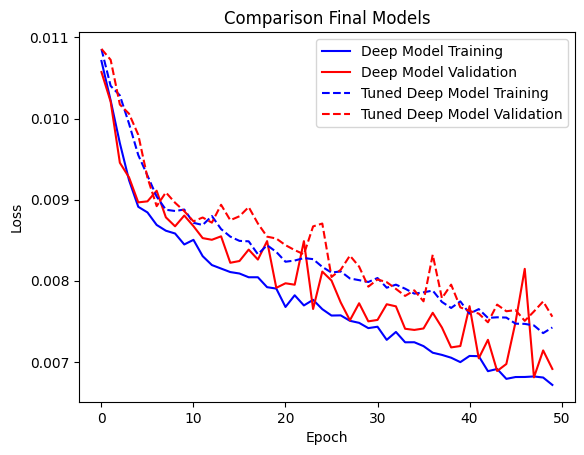

In [46]:

fig, ax = plt.subplots()
ax.plot(deep_conv_net_loss[0], 'b-', label='Deep Model Training')
ax.plot(deep_conv_net_loss[1], 'r-', label='Deep Model Validation')
ax.plot(deep_model_loss_tuned[0], 'b--', label='Tuned Deep Model Training')
ax.plot(deep_model_loss_tuned[1], 'r--', label='Tuned Deep Model Validation')
ax.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Comparison Final Models')
fig.show()

### Train on full dataset

Now we will train on the entire dataset with the tuned deep CNN model. Since there is a lot more data to train on, we will reduce the epochs.

In [53]:
torch.cuda.empty_cache() 

In [22]:

from torch import optim
best_deep_conv_model = ConvNetDeep(2, kernel_size=5, stride=1)
best_deep_learning_rate = 0.0001
train, val = train_test_split(df, stratify=df.label, test_size=0.1)
len(train), len(val)

large_train_dataset = ImageDataset(train, workspace / 'data' / 'train', tr_transf)
large_test_dataset = ImageDataset(val, workspace / 'data' / 'train', data_transformer)
batch_size = 64
train_loader = DataLoader(large_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(large_test_dataset, batch_size=batch_size, shuffle=True)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_deep_conv_model.parameters(), lr=best_deep_learning_rate)

deep_model_loss_final = train_model(best_deep_conv_model, train_loader, test_loader, criterion, optimizer, num_epochs=6)

Epoch 1/6: 100%|██████████| 3095/3095 [43:12<00:00,  1.19it/s]


Epoch 1/6
Train Loss: 0.0082
Val Loss: 0.0072
Val Accuracy: 0.8229



Epoch 2/6: 100%|██████████| 3095/3095 [33:40<00:00,  1.53it/s]


Epoch 2/6
Train Loss: 0.0067
Val Loss: 0.0064
Val Accuracy: 0.8473



Epoch 3/6: 100%|██████████| 3095/3095 [32:26<00:00,  1.59it/s]


Epoch 3/6
Train Loss: 0.0059
Val Loss: 0.0058
Val Accuracy: 0.8485



Epoch 4/6: 100%|██████████| 3095/3095 [31:47<00:00,  1.62it/s]


Epoch 4/6
Train Loss: 0.0054
Val Loss: 0.0050
Val Accuracy: 0.8819



Epoch 5/6: 100%|██████████| 3095/3095 [30:17<00:00,  1.70it/s]


Epoch 5/6
Train Loss: 0.0050
Val Loss: 0.0047
Val Accuracy: 0.8882



Epoch 6/6: 100%|██████████| 3095/3095 [27:50<00:00,  1.85it/s]


Epoch 6/6
Train Loss: 0.0046
Val Loss: 0.0043
Val Accuracy: 0.8957

[0.008224010495522308, 0.006737786608173294, 0.0059378266621537305, 0.005409097585513056, 0.004964942184221881, 0.004629203673588003] [0.007225736884243384, 0.00641866975419441, 0.005831668668864277, 0.004971888015033256, 0.004693497343615544, 0.004251201811180502]


In [23]:

torch.save(best_deep_conv_model.state_dict(), 'final_model.ckpt')

In [25]:

test_dataset = ImageDataset(val, workspace / 'data' / 'train', data_transformer)

In [ ]:


from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
# Test the model
best_deep_conv_model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    predicted = [] 
    truth_labels = [] 
    for images, labels in test_dataset:
        images = images.to(device)
        labels = labels
        outputs = best_deep_conv_model(images.unsqueeze(0))
        _, pred = torch.max(outputs.data, 1)
        predicted.append(pred)
        truth_labels.append(labels)
        total += 1
        correct += (pred == labels).sum().item()
          
    print('Accurracy: {} %'.format(100 * correct / total))




Accuracy of 89.6% on test data! This could likely be improved by:
1. Longer training time 
2. Better hyperparameter tuning 
3. More data

0.8961959732763713


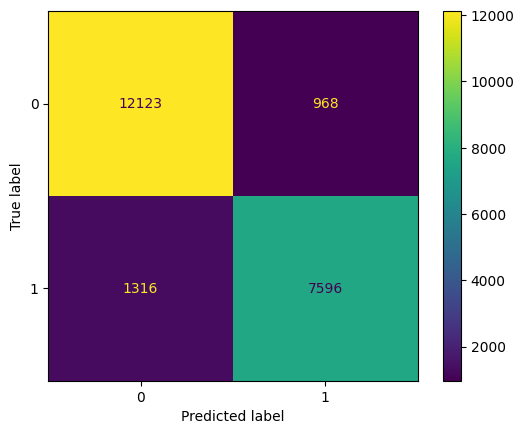

In [27]:
predicted = [pred.cpu().detach().numpy() for pred in predicted]

cm = confusion_matrix(truth_labels, predicted)
accuracy = accuracy_score(truth_labels, predicted)
print(accuracy)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


# Conclusion

For this project we:
1. Created a dataloader that creates synthetic data from the training set
2. Evaluated different architectures on a subset of training data
3. Performed Hyperparameter optimization 
4. Achieved 89.6% accuracy on the test set for classification accuracy

This project could be improved by:
1. Better hyperparameter tuning methods 
2. Longer training time 
3. More extensive model design and iteration 